# Project 3
## Team members Arick Smith And Treyson Grange

## Ideas

- Scrape rolling stones for most mentioned artists
- Scrape cooking recipes, find trends in ingredients and how expensive the recipes are
- Working with the data creation from UCI mountain Bike world racing data set. (CHOOSEN)


## TASKS
- need to use the requests, Beautiful Soup, html5lib, and/or API libraries (e.g. Twitter, RottenTomatoes) to get web content.
- Your analysis should include at least four techniques that we've discussed in class, and they should all contribute in a meaningful way to telling the story. 
- Make Project Report
- Make Presentation



In [2]:
# Common imports for the parsing of website data
from bs4 import BeautifulSoup
import requests
import re


#Common imports for use in the data visualization
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import scipy.stats as stats





Working on the parsing of website data

In [ ]:
call_web = "https://ucimtbworldseries.com/teams"

site = requests.get(call_web)

og_web_html = ''

og_web_html = site.text
print(og_web_html[:500])

In [ ]:
team_matches = len(list(re.finditer('/teams/', str(og_web_html))))

print("the total count of teams is likely half this number ", team_matches)



In [ ]:
soup = BeautifulSoup(og_web_html)


#Using the same code as the inclass example I found that the items classed as flex-shrink-0 would have our hyperlinks
teams = [a['href'] for div in soup.find_all('div', {'class':'flex-shrink-0'}) for a in div.find_all('a')]
# Removing the home dir
teams.remove('/')
print(teams)
print(len(teams))

#There are a total of 196 teams involved


In [ ]:
#Going to enter each team and make a compilition of the members that compose it (Getting each url to a team member)
players_links = []

for team in teams:
    cur_team = requests.get(team)
    if cur_team.status_code == 200:
        sur_team_text = cur_team.text

        team_soup = BeautifulSoup(sur_team_text)

        current_links = [a['href'] for div in team_soup.find_all('div', {'id':'team-riders'}) for a in div.find_all('a')]

        #Breaking apart links to have in one massive player link list
        for i in current_links:
            players_links.append(i)

#All player links
players_links


In [ ]:
# getTopElements
# input HTML Soup
# Output: Team, Nationality, age, format, category
def getTopElements(rider_soup):
    divList = rider_soup.find('div', class_='flow-root bg-white')# this i gets the list at the top of the page
    ul_element = divList.find('ul', class_='divide-y divide-gray-200 bg-white m-4')
    output = []
    output.append(rider_soup.find('p', class_='truncate text-xl font-headline text-gray-900 uppercase').text)
    for li_element in ul_element.find_all('li'):
        for div_element in li_element.find_all('div'):
            if div_element.find('svg'):
                continue
            if not div_element.find('div'):
                continue
            
            for p_element in div_element.find_all('p'):
                if p_element.find('span'):
                    continue
                output.append(p_element.text)

            

    return output


def getRiderResults(rider_soup):
    allPlacements = []
    table = rider_soup.find('table')
    tbody = table.find('tbody')
    for tr in tbody.find_all('tr'):
        th_element = tr.find('td', class_='whitespace-nowrap py-4 pl-4 pr-3 text-center text-sm font-medium text-gray-900 sm:pl-0')
        th_text = th_element.text.strip().rstrip('\n')
        allPlacements.append(th_text)
    
    return allPlacements
        
        
        


In [ ]:
#The following will create a rider entry to a csv file
#This will contain a few of the following peices of data: NAME,AGE,NATIONALITY,CATEGORY, etc...
with open('riders.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    filewriter.writerow(['Name', 'Age', 'Nationality','Team', 'Category', 'Formats', 'AVG_Place', 'TTL_First', 'TTL_Top_Ten', 'TTL_Races_2023', 'AVG_T_Behind_First', 'XCOWCP', 'XCCWCP'])
    
    for rider in players_links:
        # print(rider)
        cur_rider = requests.get(rider)
        if cur_rider.status_code == 200:
            cur_rider_html = cur_rider.text
            rider_soup = BeautifulSoup(cur_rider_html)

            # For name, age, nationality, category, and formats
            output = getTopElements(rider_soup)
            print(output)
            # For placements of every race
            allPlacements = getRiderResults(rider_soup)
            
            # For AVG_Place
            total = 0
            while "DNF" in allPlacements:
                allPlacements.remove("DNF")  # Remove "DNF" from the list
            while "DSQ" in allPlacements:
                allPlacements.remove("DSQ")  # Remove "DNF" from the list
            while "DNS" in allPlacements:
                allPlacements.remove("DNS")  # Remove "DNS" from the list
            for num in allPlacements:
                try:
                    total += float(num)
                except ValueError:
                    pass  # Ignore non-numeric values like "DNS"
            
            count = len(allPlacements)
            #For TTL_First and TTL_Top_Ten
            TTLFirstCounter = 0
            TTLTop10Counter = 0
            for item in allPlacements:
                if int(item)<= 1:
                    TTLFirstCounter += 1
                if int(item)<= 10:
                    TTLTop10Counter += 1


            
            if count == 0:
                average = 0
            else:    
                average = round(total / count)


            try:
                formatCleaned = output[7].replace("\n","").strip().split()
                categoryCleaned = output[9].replace("\n","").strip().split()
                filewriter.writerow([output[0].strip(), output[5].strip(), output[3].strip(), output[1].strip(), categoryCleaned, formatCleaned, average, TTLFirstCounter, TTLTop10Counter, len(allPlacements), 0, 0, 0])
            except IndexError:
                pass
            
    

# Transition from gathering Data to Interpreting the data
## Questions we seek to answer

- Whos the nation to beat in world series Mountain Biking?
- Does America Beat out the British?
- What contributes to riders getting First Place?
- Does a DNF mean they are an often poor racer? (Bottom half of leaderboard)

In [3]:
#Reading in the data from our created data set. This ensures it works with the code without the need to make the CSV file every time

rider_df = pd.read_csv('riders.csv', encoding='utf-8')
rider_df.shape

(872, 13)

In [4]:
# Grab all of the rider info for the brits for later use

rider_UK = rider_df[rider_df['Nationality'] == "United Kingdom"]
rider_UK.head(5)


,Name,Age,Nationality,Team,Category,Formats,AVG_Place,TTL_First,TTL_Top_Ten,TTL_Races_2023,AVG_T_Behind_First,XCOWCP,XCCWCP
0,Luke WILLIAMSON,22,United Kingdom,555 GRAVITY RACING,"['Men', 'Elite']",[],66,0,0,10,0,0,0
1,Ryan BRANNEN,21,United Kingdom,555 GRAVITY RACING,"['Men', 'Elite']",[],125,0,0,3,0,0,0
2,Douglas GOODWILL,20,United Kingdom,555 GRAVITY RACING,"['Men', 'Elite']",[],97,0,0,6,0,0,0
64,Ella CONOLLY,26,United Kingdom,CANNONDALE ENDURO TEAM,"['Women', 'Elite']",['EDR'],5,0,4,5,0,0,0
69,Charlie Aldridge,23,United Kingdom,CANNONDALE FACTORY RACING,"['Men', 'Elite']",[],22,0,4,14,0,0,0


In [5]:
# Grab all of the rider info for the yanks for later use

rider_USA = rider_df[rider_df['Nationality'] == "United States"]
rider_USA.head(5)


,Name,Age,Nationality,Team,Category,Formats,AVG_Place,TTL_First,TTL_Top_Ten,TTL_Races_2023,AVG_T_Behind_First,XCOWCP,XCCWCP
15,Lasse KONECNY,21,United States,BEAR NATIONAL TEAM,"['Men', 'U23']","['XCO', 'XCC']",43,0,0,3,0,0,0
16,Daxton MOCK,23,United States,BEAR NATIONAL TEAM,"['U23', 'Men']","['XCO', 'XCC']",102,0,0,2,0,0,0
17,Cayden Parker,20,United States,BEAR NATIONAL TEAM,"['U23', 'Men']","['XCO', 'XCC']",57,0,0,5,0,0,0
18,Cobe FREEBURN,23,United States,BEAR NATIONAL TEAM,"['U23', 'Men']","['XCO', 'XCC']",0,0,0,0,0,0,0
19,Carson HAMPTON,21,United States,BEAR NATIONAL TEAM,"['Men', 'U23']","['XCO', 'XCC']",44,0,0,3,0,0,0


In [6]:
# Before only comparing the US and UK Lets find out which nation is running the best track record 

nationalities = rider_df['Nationality'].unique()
nationalities

array(['United Kingdom', 'Italy', 'Netherlands', 'New Zealand', 'Germany',
       'Belgium', 'Switzerland', 'United States', 'France',
       'Czech Republic', 'Canada', 'Spain', 'Argentina', 'Estonia',
       'Portugal', 'Brazil', 'Denmark', 'South Africa', 'Austria',
       'Colombia', 'Mexico', 'Australia', 'Norway', 'Sweden', 'Ireland',
       'Slovakia', 'Cyprus', 'Lithuania', 'Slovenia', 'Bulgaria',
       'Hungary', 'Israel', 'Poland', 'Ukraine', 'Latvia', 'Nationality',
       'Venezuela', 'Andorra', 'Chile', 'Puerto Rico', 'Finland',
       'Greece', 'Lesotho', 'Iran, Islamic Republic of', 'Thailand',
       'Turkey', 'Japan', 'Liechtenstein', 'Romania'], dtype=object)

[]

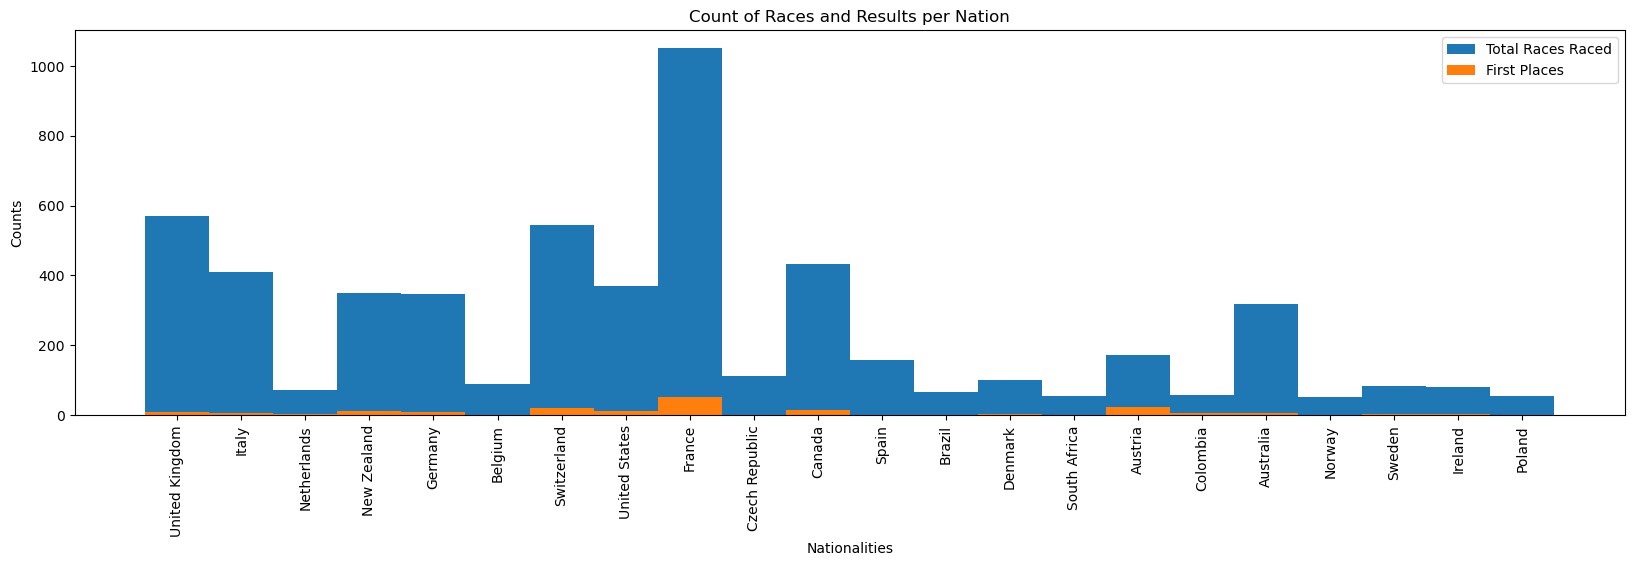

In [7]:
first_place_count = {}
TTL_race_count = {}
percent_first = {}


for nation in nationalities:
    nation_df = rider_df[rider_df['Nationality'] == nation]
    if nation_df['TTL_Races_2023'].sum() > 50:
        nation_first_place = nation_df['TTL_First'].sum()
        nation_TTL_races = nation_df['TTL_Races_2023'].sum()

        percent_of_races_first = nation_first_place/nation_TTL_races * 100

        first_place_count[nation] = nation_first_place
        TTL_race_count[nation] = nation_TTL_races
        percent_first[nation] = percent_of_races_first

    # A verbal printing of the data given in the graph
    #print(f'Total First places is: {nation_first_place}|| In total {nation} racers competed in {nation_TTL_races} in 2023. As a nation they get first {percent_of_races_first}% of the time')


# Ploting the number or races ran by the given countries and the number of 1st places they won
plt.figure(figsize=(20,5))
plt.bar(range(len(TTL_race_count)), list(TTL_race_count.values()), tick_label=list(TTL_race_count.keys()), width=1, label="Total Races Raced")
plt.bar(range(len(first_place_count)), list(first_place_count.values()), tick_label=list(first_place_count.keys()), width=1, label="First Places")

plt.legend()
plt.xticks(rotation=90)
plt.xlabel("Nationalities")
plt.ylabel("Counts")
plt.title("Count of Races and Results per Nation")
plt.plot()


[]

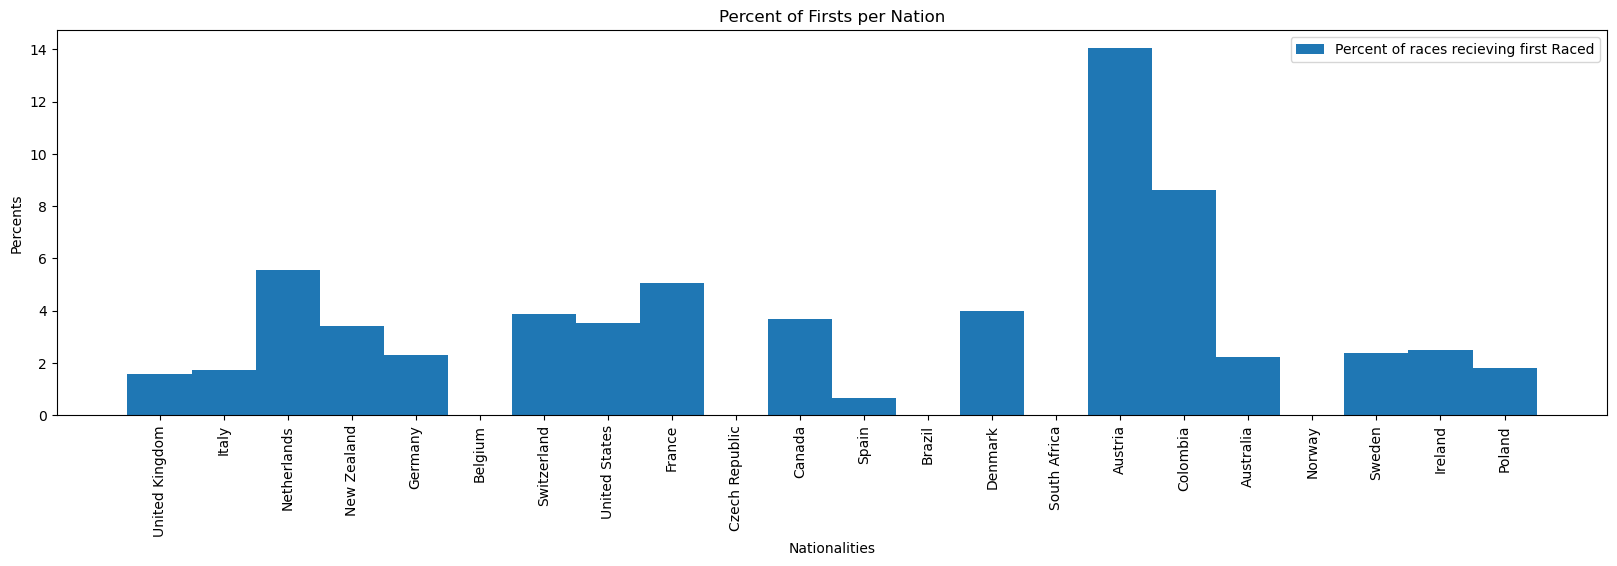

In [8]:
# Don't know if this is useful but I'll keep working

plt.figure(figsize=(20,5))
plt.bar(range(len(percent_first)), list(percent_first.values()), tick_label=list(percent_first.keys()), width=1, label="Percent of races recieving first Raced")

plt.legend()
plt.xticks(rotation=90)
plt.xlabel("Nationalities")
plt.ylabel("Percents")
plt.title("Percent of Firsts per Nation")
plt.plot()


This is interesting but the statistics are extreamly unbalanced with the number of riders for each country. Skilled or unskilled.

So let's look at the top performers in each country. I.e. those with most first place positions or top ten


In [9]:
# getting top 5 riders from each nation

top_3_df = pd.DataFrame(columns=rider_df.columns)

for country in nationalities:
    top_five_First = rider_df[rider_df['Nationality'] == country]
    if len(top_five_First) >= 3:
        top_five_First = top_five_First.sort_values(by=['TTL_First', 'TTL_Top_Ten'], ascending=False)
        top_five_Ten = top_five_First[:3]
        top_3_df = pd.concat([top_3_df, top_five_Ten])

top_3_df = top_3_df.reset_index(drop=True)

top_3_df.head(5)


,Name,Age,Nationality,Team,Category,Formats,AVG_Place,TTL_First,TTL_Top_Ten,TTL_Races_2023,AVG_T_Behind_First,XCOWCP,XCCWCP
0,Thomas PIDCOCK,25,United Kingdom,INEOS GRENADIERS,"['Men', 'Elite']","['XCO', 'XCC']",6,3,6,8,0,0,0
1,Jordan WILLIAMS,20,United Kingdom,SPECIALIZED GRAVITY,"['Men', 'Elite']",[],23,2,8,21,0,0,0
2,Evie RICHARDS,27,United Kingdom,TREK FACTORY RACING XC,"['Women', 'Elite']","['XCO', 'XCC']",8,1,11,15,0,0,0
3,Gloria SCARSI,24,Italy,CANYON CLLCTV DAINESE,"['Women', 'Elite']",['EDR'],8,1,12,16,0,0,0
4,Sophie RIVA,21,Italy,SUNN FRENCH CO BY ALPE D'HUEZ,"['Women', 'U21']",['EDR'],5,1,8,8,0,0,0


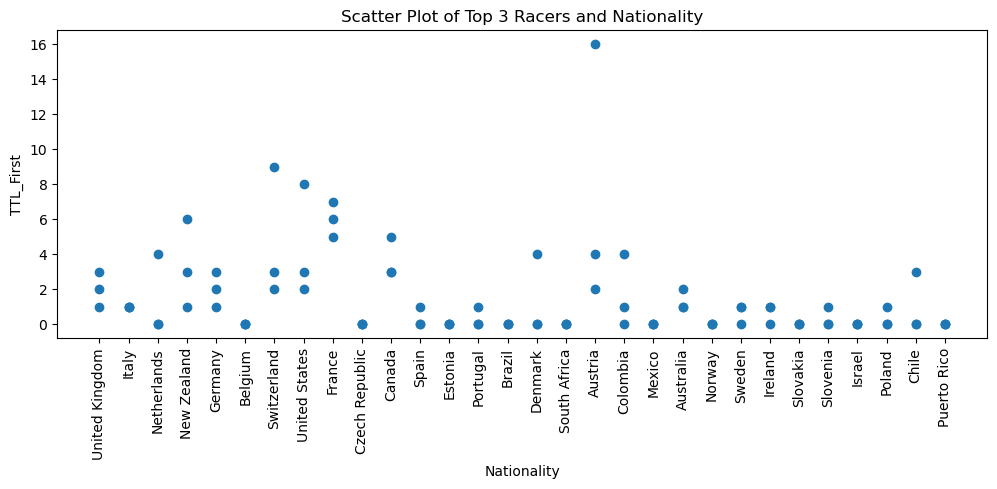

In [10]:
plt.figure(figsize=(12,4))
plt.scatter(top_3_df["Nationality"], top_3_df['TTL_First'])
plt.xlabel('Nationality')
plt.ylabel('TTL_First')
plt.title('Scatter Plot of Top 3 Racers and Nationality')
plt.xticks(rotation=90)
plt.show()

The statistic for the Age is -0.024289446306009387. It's Pearson p value is 0.47429318776369384
The statistic for the TTL_Top_Ten is 0.5668036521187952. It's Pearson p value is 4.321128385787637e-75
The statistic for the TTL_Races_2023 is 0.28338664861113744. It's Pearson p value is 1.568347894358597e-17


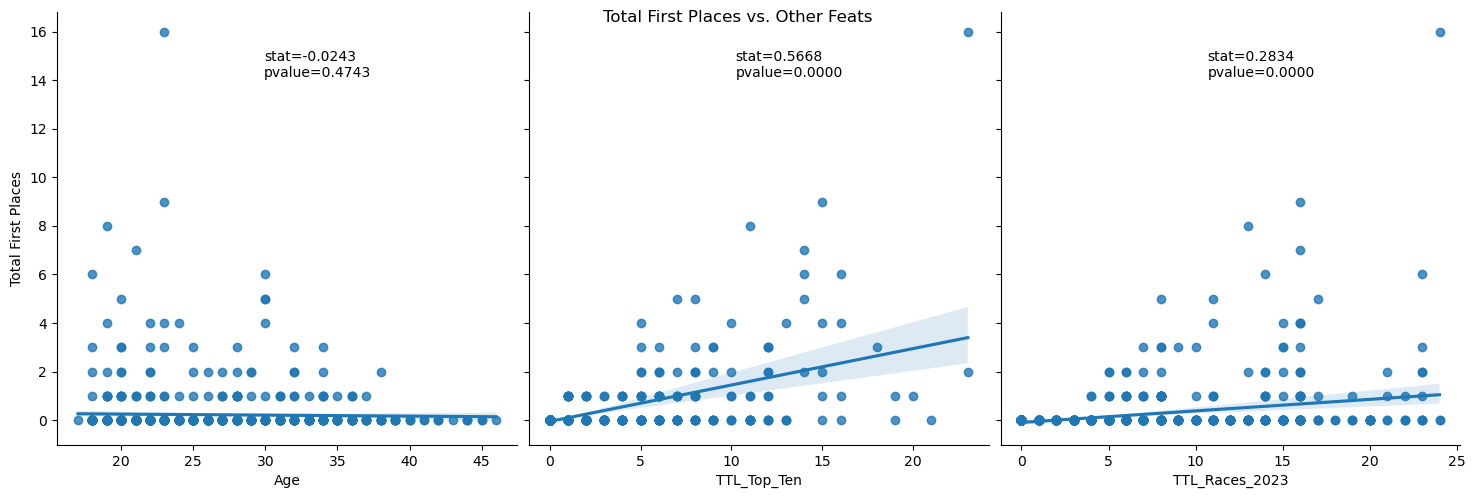

In [11]:

comparison_feats = ['Age', 'TTL_Top_Ten', 'TTL_Races_2023']
for feat in comparison_feats:
    rider_df[feat] = pd.to_numeric(rider_df[feat], errors='coerce')

rider_df_cleaned = rider_df.dropna(subset=['TTL_First'] + comparison_feats)

sns.pairplot(data=rider_df_cleaned, x_vars=comparison_feats, y_vars='TTL_First', kind='reg', height=5)


for ax, feat in zip(plt.gcf().axes, comparison_feats):
    
    stat, pvalue = stats.pearsonr(rider_df_cleaned['TTL_First'], rider_df_cleaned[feat])
    print(f"The statistic for the {feat} is {stat}. It's Pearson p value is {pvalue}")
    ax.annotate(f"{stat=:.4f}\n{pvalue=:.4f}", xy=(0.45, 0.85), xycoords="axes fraction")
    ax.set_xlabel(feat)
    ax.set_ylabel("Total First Places")

plt.suptitle('Total First Places vs. Other Feats')
plt.show()

T Test  

In [12]:
#display(stats.ttest_ind(juan.H, john.H))# ind means independent, so the two wamples are independent
display(stats.ttest_ind(rider_UK['TTL_First'], rider_USA['TTL_First']))

Ttest_indResult(statistic=-0.7564308136258249, pvalue=0.4509113770237613)

With a p-value of 0.451, this suggests that there is not enough evidence to reject the null hypothesis, assuming a significance level of 0.05. The null hypothesis in this case would be that there is no difference in the total number of first place finishes between riders from the UK and riders from the USA.

In [13]:
display(stats.ttest_ind(rider_UK['AVG_Place'], rider_USA['AVG_Place']))

Ttest_indResult(statistic=1.4203034814490667, pvalue=0.1581786811979614)

With a p-value of 0.158, this suggests that there is not enough evidence to reject the null hypothesis, assuming a significance level of 0.05. The null hypothesis in this case would be that there is no difference in average placement between riders from the UK and riders from the USA.

In [36]:
t_statistic, p_statistic = stats.ttest_ind(rider_UK['TTL_Top_Ten'], rider_USA['TTL_Top_Ten'])
display(t_statistic, p_statistic)




-0.3384744977555206

0.7356122880718394

Lets graph it

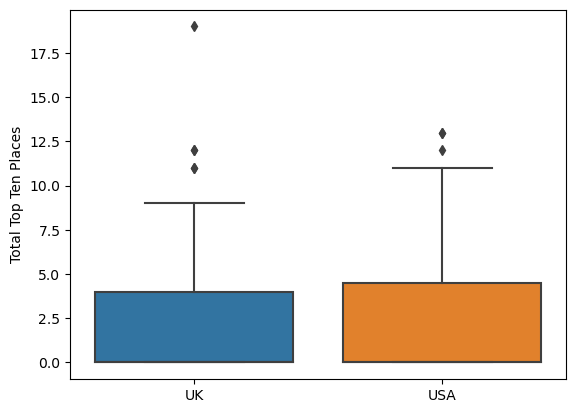

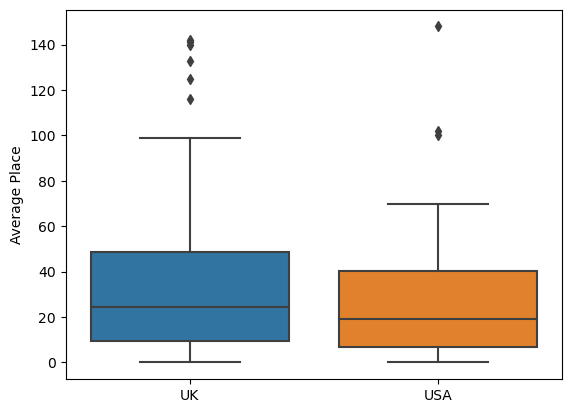

In [37]:
plot = sns.boxplot( data=[rider_UK['TTL_Top_Ten'], rider_USA['TTL_Top_Ten']])
plot.set_xticklabels(['UK', 'USA'])
plot.set_ylabel('Total Top Ten Places')
plt.show()

plot = sns.boxplot( data=[rider_UK['AVG_Place'], rider_USA['AVG_Place']])
plot.set_xticklabels(['UK', 'USA'])
plot.set_ylabel('Average Place')
# so this is a box plot of the average place of the UK and USA riders, the outliers above are really really bad. 
plt.show()

Total Top Ten Places: This boxplot shows that USA has a slight edge in terms of interquartile range, and each box plot includes no median line, because there are so many players who have never finished in the top 10, so the median can be 0! Also, interestingly enough, the highest outlier goes to UK, standing at about 19 top ten finishes! This person is Tahnee Seagrave, who has 22 races total, which is a top ten rate of .86! This is impressive. But you know whats even better? The person in the USA who has the most top ten placements, is Taylor Ostgaard, who placed top 10 in all of her 13 races. WoW!

Average Places: This box plot is different in that the closer to zero the better. So we see that USA has a lower median, and IQR. Interestingly, UK has a lot more high outliers than USA has, their worst sitting at 140. Though USA has 1 outlier that beats all of them, jumping just above the 145 mark. 

In [39]:
# This is Tahnee
# player_highest_top_ten = rider_UK.loc[rider_UK['TTL_Top_Ten'].idxmax()]
# print(player_highest_top_ten)

# This is Taylor
# player_highest_top_ten_USA = rider_USA.loc[rider_USA['TTL_Top_Ten'].idxmax()]
# print(player_highest_top_ten_USA)


Name                     Tahnee SEAGRAVE
Age                                   29
Nationality               United Kingdom
Team                   CANYON CLLCTV FMD
Category              ['Women', 'Elite']
Formats                               []
AVG_Place                              7
TTL_First                              0
TTL_Top_Ten                           19
TTL_Races_2023                        22
AVG_T_Behind_First                     0
XCOWCP                                 0
XCCWCP                                 0
Name: 97, dtype: object
Name                            Taylor OSTGAARD
Age                                          19
Nationality                       United States
Team                  TRANSITION FACTORY RACING
Category                    ['Women', 'Junior']
Formats                                      []
AVG_Place                                     7
TTL_First                                     0
TTL_Top_Ten                                  13
TTL_Races_2